# MODEL DEVELOPMENT AND FEATURE IMPORTANCE: XGBOOST

## DATA PREPROCESSING AND MODEL DEVELOPMENT

In [ ]:
import numpy as np
import pandas as pd

# datasets
data_to_merge = pd.read_csv("../Data/dataset_clean_medications.csv")  # Vero's merged dataset
slopes = pd.read_csv("../Data/slopes_0.0014.csv")  # -0.0014 slope patient split
clinical_bm_data = pd.read_csv("../Data/MERGED_DATA_10202024_DS_UPDATE3_WITH_INDIVIDUAL_MOCA_AND_FAMILIYHIST.csv")

# Merge on 'PATNO' to get common rows
merged_data = pd.merge(slopes[['PATNO', 'Label']], data_to_merge, on='PATNO', how='inner')
merged_data = pd.merge(merged_data, clinical_bm_data, on='PATNO', how='inner')

# get the list of columns from each dataset (excluding 'PATNO' and 'Label')
data_to_merge_columns = [col for col in data_to_merge.columns if col not in ['PATNO']]
clinical_bm_columns = [col for col in clinical_bm_data.columns if col not in ['PATNO']]
all_columns = data_to_merge_columns + clinical_bm_columns


#################################################  DATA CLEANING  ##################################################
########## Cleaning columns

# get NaN percentage on columns
nan_percentage = (merged_data.isna().sum() / len(merged_data)) * 100

# a good threshold for Nan percenage would be 40%, more than half is avaiable for missing data
# IDENTIFY THE COLUMNs meeting this threshold 
columns_to_drop = nan_percentage[nan_percentage > 40].index.tolist()

# drop the columns identified as having high Nan values
merged_data_cleaned = merged_data.drop(columns=columns_to_drop)

######## Cleaning Rows
# similarly set a threshold for the row missing data o eliminate those patients that have high perce ntage of Nan's
# set to 15% threshold, as we really need to preserve feature completeness to build a model on mostly complete data
row_nan_percentage = (merged_data_cleaned.isna().sum(axis=1) / merged_data_cleaned.shape[1]) * 100
rows_to_keep = row_nan_percentage < 15
df_cleaned_rows = merged_data_cleaned[rows_to_keep].reset_index(drop=True)

############################################## CREATION OF 3 TRAINING DATASETS ##################################

# Since we did cleaning, make sure that each of the datasets is composed of columns that were actually not cleaned out
data_to_merge_cols_present = [col for col in data_to_merge_columns if col in df_cleaned_rows.columns]
clinical_bm_cols_present = [col for col in clinical_bm_columns if col in df_cleaned_rows.columns]
all_cols_present = data_to_merge_cols_present + clinical_bm_cols_present

# Dataset 1: clinical lab tests/biomarker feats only
df_clinical_only = df_cleaned_rows[['PATNO', 'Label'] + clinical_bm_cols_present].copy()

# Dataset 2:  clinical features mostly
df_data_only = df_cleaned_rows[['PATNO', 'Label'] + data_to_merge_cols_present].copy()

# Dataset 3: all features
df_both = df_cleaned_rows[['PATNO', 'Label'] + all_cols_present].copy()

# For our model training th target variable is the generated labels. .target variable
target_variable = 'Label'

# features to exclude since they are duplicated or are not informative in splitting the two label group/patients
common_features_to_drop = [
    "Unnamed: 0", "EVENT_ID", "SAA_Status", "CSFSAA", "updrs1_score.1",
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT', 'RBC Morphology',
]

# features known that are categorical, from detailed exploration of each of the feaures  
specified_categorical_features = [
    'APOE', 'NSD_STAGE', 'fampd_bin', 'race', 'APOE_e4', 'DOMSIDE'
]

# This function prepares the datasets to remove the problematic features and also prepares the X and y datasets
def prepare_dataset(df):
    features_to_drop = ['Label', 'PATNO'] + common_features_to_drop
    # Remove any features that are not in the DataFrame to avoid errors
    features_to_drop = [feature for feature in features_to_drop if feature in df.columns]
    X = df.drop(columns=features_to_drop)
    y = df[target_variable]
    return X, y

# prepare X and y datasets according to the 3 dataset descriptions explained above
X_clinical, y_clinical = prepare_dataset(df_clinical_only)
X_data, y_data = prepare_dataset(df_data_only)
X_both, y_both = prepare_dataset(df_both)

# getting numerical and categorical columns for each dataset
def get_column_types(X, specified_categorical_features):
    # all features not in specified_categorical_features are numerical, so we can just filter based on that
    categorical_cols = [col for col in X.columns if col in specified_categorical_features]
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    return numerical_cols, categorical_cols

# apply the bumerical feature identification function to each of the 3 dataset subsets 
numerical_cols_clinical, categorical_cols_clinical = get_column_types(X_clinical, specified_categorical_features)
numerical_cols_data, categorical_cols_data = get_column_types(X_data, specified_categorical_features)
numerical_cols_both, categorical_cols_both = get_column_types(X_both, specified_categorical_features)

# We found that some of the numerical features actually have some strings like "<80", so we coerce these errors to Nan them, hence converting the entire numerical column
def ensure_numerical(X, numerical_cols):
    for col in numerical_cols:
        if X[col].dtype not in ['int64', 'float64']:
            X[col] = pd.to_numeric(X[col], errors='coerce')
    return X

# apply the function to ensure numerical columns are numerical by coercing numerical columns
X_clinical = ensure_numerical(X_clinical, numerical_cols_clinical)
X_data = ensure_numerical(X_data, numerical_cols_data)
X_both = ensure_numerical(X_both, numerical_cols_both)

###############################################   XGBOOST MODEL DEVELOPMENT ##############################################################
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, fbeta_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# split the indices for the same train-test split for all datasets
train_indices, test_indices = train_test_split(
    df_cleaned_rows.index, test_size=0.2, stratify=df_cleaned_rows[target_variable], random_state=42
)

############################################   OPTUNA OBJECTIVE DEFINITION ##############################################


def run_model(X, y, numerical_cols, categorical_cols, description):
    ''' This function runs hyperparameter search using optuna, and also performs final evaluation on data unseen by the hyperparameter search process.
    This split is in the first chunk of the function, and reserves heldout dataset for final evaluation on the model trained with the best parameters and the full
    training dataset. This function returns the performance metrics of the best model as evaluated on the hold out data
    
    INPUT: 1) Preprocessed X and y data, 2) list of the numerical columns 3) and categorical columns, 4) description title 
    OUTPUT: performance metrics of the best model, tested on the hold out data
    * requires  already having pre-defined train and test indices for appropriate comparison of models on the same training and hold out data'''


    print(f"\n=== Training and Evaluating Model: {description} ===")
    
    # Use the predefined train and test indices
    X_train_full = X.loc[train_indices].reset_index(drop=True)
    X_heldout = X.loc[test_indices].reset_index(drop=True)
    y_train_full = y.loc[train_indices].reset_index(drop=True)
    y_heldout = y.loc[test_indices].reset_index(drop=True)
    
    #  Optuna objective function to optimize F-beta score (beta=1.5) for class 1, to prioritize the recall for class1
    def objective(trial):
        # Hyperparameters 
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.6),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
            'lambda': trial.suggest_float('lambda', 1e-2, 50.0),  # L2 regularization
            'alpha': trial.suggest_float('alpha', 1e-2, 50.0)    # L1 regularization
        }
    
        # do 5-fold cv
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
        #F-beta scores for class 1 across the 5 folds
        all_fbeta_scores_class1 = []
    
        for train_idx, val_idx in skf.split(X_train_full, y_train_full):
            #get data into training and validation folds
            X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
            y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
            # defined processsing pipelines for imputing with sinple imputer and , also onehot encode the categorical feats
            num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy="mean")),                               #numerical pipeline
                ('scaler', StandardScaler())
            ])
            
            if categorical_cols:
                # encode the categoricals feats
                # if a column name hasnt been seen by processor, drop it. 
                cat_transformer = Pipeline(steps=[                                              #categorical pipeline, first impute with mode
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))                #then onehot encode
                ])
                preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', num_transformer, numerical_cols),
                        ('cat', cat_transformer, categorical_cols)                  
                    ],
                    remainder='drop'  
                )
            else:
                preprocessor = ColumnTransformer(                #for numerical feats 
                    transformers=[
                        ('num', num_transformer, numerical_cols)
                    ],
                    remainder='drop' 
                )
    
            # preprocess the training and validation data
            X_train_preprocessed = preprocessor.fit_transform(X_train)
            X_val_preprocessed = preprocessor.transform(X_val)
    
            # SMOTE to handle class imbalance
            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
    
            # XGBoost model training
            model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train_smote, y_train_smote)
    
            # predictions
            y_pred = model.predict(X_val_preprocessed)
    
            # get F-beta score for class 1 with beta=1.5
            fbeta_class1 = fbeta_score(y_val, y_pred, beta=1.5, average='binary', pos_label=1)
            all_fbeta_scores_class1.append(fbeta_class1)
    
        # F-beta score for class 1 across folds
        avg_fbeta_class1 = np.mean(all_fbeta_scores_class1)
    
        return avg_fbeta_class1
    
    ########################## RUN OPTUNA OPTIMIZATION TO MAXIMIZE THE F-beta for class 1 ###################################
    # Optimization study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=200)
    
    # Preprocessing pipelines as described above
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])
    
    if categorical_cols:
 
        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, numerical_cols),
                ('cat', cat_transformer, categorical_cols)
            ],
            remainder='drop'  
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, numerical_cols)
            ],
            remainder='drop'  
        )
    
    # fit transform preprocess the full training dataset, and transform the held out, unseen data
    X_train_full_preprocessed = preprocessor.fit_transform(X_train_full)
    X_heldout_preprocessed = preprocessor.transform(X_heldout)
    
    # smote on the full training set, for class imbalance
    smote = SMOTE(random_state=42)
    X_train_full_smote, y_train_full_smote = smote.fit_resample(X_train_full_preprocessed, y_train_full)
    
    # using the best params from optuna study, train with tat on the preprocessed full training datasaet
    final_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    final_model.fit(X_train_full_smote, y_train_full_smote)
    
    # evaluate on the transformed held-out test set
    y_pred_heldout = final_model.predict(X_heldout_preprocessed)
    
    # assess accuracy measures
    heldout_accuracy = accuracy_score(y_heldout, y_pred_heldout)
    
    heldout_precision_per_class = precision_score(y_heldout, y_pred_heldout, labels=[0, 1], average=None)
    heldout_recall_per_class = recall_score(y_heldout, y_pred_heldout, labels=[0, 1], average=None)
    heldout_f1_per_class = f1_score(y_heldout, y_pred_heldout, labels=[0, 1], average=None)
    heldout_fbeta_per_class = fbeta_score(y_heldout, y_pred_heldout, beta=2, labels=[0, 1], average=None)
    
    # report of model performance
    print("\nClassification Report (Held-Out Test Set):\n", classification_report(y_heldout, y_pred_heldout))
    print(f"Accuracy (Held-Out Test Set): {heldout_accuracy:.4f}")
    
    print(f"\nMetrics for Class 0:")
    print(f"Precision Class 0 (Held-Out Test Set): {heldout_precision_per_class[0]:.4f}")
    print(f"Recall Class 0 (Held-Out Test Set): {heldout_recall_per_class[0]:.4f}")
    print(f"F1-Score Class 0 (Held-Out Test Set): {heldout_f1_per_class[0]:.4f}")
    print(f"F-beta Score (beta=2) Class 0 (Held-Out Test Set): {heldout_fbeta_per_class[0]:.4f}")
    
    print(f"\nMetrics for Class 1:")
    print(f"Precision Class 1 (Held-Out Test Set): {heldout_precision_per_class[1]:.4f}")
    print(f"Recall Class 1 (Held-Out Test Set): {heldout_recall_per_class[1]:.4f}")
    print(f"F1-Score Class 1 (Held-Out Test Set): {heldout_f1_per_class[1]:.4f}")
    print(f"F-beta Score (beta=2) Class 1 (Held-Out Test Set): {heldout_fbeta_per_class[1]:.4f}")
    
    # return model performance metricsfor proper comparison
    return {
        'Accuracy': heldout_accuracy,
        'Precision Class 0': heldout_precision_per_class[0],
        'Recall Class 0': heldout_recall_per_class[0],
        'F1-Score Class 0': heldout_f1_per_class[0],
        'F-beta Score Class 0 (beta=2)': heldout_fbeta_per_class[0],
        'Precision Class 1': heldout_precision_per_class[1],
        'Recall Class 1': heldout_recall_per_class[1],
        'F1-Score Class 1': heldout_f1_per_class[1],
        'F-beta Score Class 1 (beta=2)': heldout_fbeta_per_class[1],
    }




In [8]:
#############################################  RUN THIS CELL TO DO HYPERPARAMETER TUNING ON THE THREE DIFERENT DATASET ########################################### might take a while to run
############################################### A comparison report of performance will be generated ########################################################################

# Do hyperparam tuning using funcion above on model with clinical lab tests/ biomarkers features only
metrics_clinical = run_model(
    X_clinical, y_clinical, numerical_cols_clinical, categorical_cols_clinical, "Clinical Features Only"
)

# Do hyperparam tuning using funcion above on model with clinical data only
metrics_data = run_model(
    X_data, y_data, numerical_cols_data, categorical_cols_data, "Data_to_Merge Features Only"
)

# Do hyperparam tuning using funcion above on model with all features in datasets
metrics_both = run_model(
    X_both, y_both, numerical_cols_both, categorical_cols_both, "Both Clinical and Data_to_Merge Features"
)

# compare the evaluation metrics of the models from different datasets that have been hyperparaeter optimized with Optuna
print("Evaluation Metrics")
comparison_df = pd.DataFrame({
    'Clinical Only': metrics_clinical,
    'Data_to_Merge Only': metrics_data,
    'Both Features': metrics_both
})
print(comparison_df)

[I 2024-12-13 00:05:47,449] A new study created in memory with name: no-name-5e23bf25-3884-4b0f-93a6-753fa15862e0



=== Training and Evaluating Model: Clinical Features Only ===


[I 2024-12-13 00:05:49,732] Trial 0 finished with value: 0.45118489047810606 and parameters: {'learning_rate': 0.09222503697592335, 'max_depth': 7, 'n_estimators': 466, 'min_child_weight': 7.097527778545077, 'subsample': 0.5462981141272341, 'colsample_bytree': 0.6582516207030477, 'scale_pos_weight': 12.913151167201363, 'lambda': 37.684989777359455, 'alpha': 0.8834917725797118}. Best is trial 0 with value: 0.45118489047810606.
[I 2024-12-13 00:05:52,367] Trial 1 finished with value: 0.5321085908681495 and parameters: {'learning_rate': 0.4954296791144682, 'max_depth': 12, 'n_estimators': 1280, 'min_child_weight': 9.468494981302072, 'subsample': 0.7531306641707423, 'colsample_bytree': 0.5719454356478775, 'scale_pos_weight': 5.382621398940255, 'lambda': 1.7703534837673773, 'alpha': 19.537029882642745}. Best is trial 1 with value: 0.5321085908681495.
[I 2024-12-13 00:05:56,833] Trial 2 finished with value: 0.445836265540699 and parameters: {'learning_rate': 0.15988393631855954, 'max_depth':


Classification Report (Held-Out Test Set):
               precision    recall  f1-score   support

           0       0.84      0.52      0.64        50
           1       0.25      0.62      0.36        13

    accuracy                           0.54        63
   macro avg       0.54      0.57      0.50        63
weighted avg       0.72      0.54      0.58        63

Accuracy (Held-Out Test Set): 0.5397

Metrics for Class 0:
Precision Class 0 (Held-Out Test Set): 0.8387
Recall Class 0 (Held-Out Test Set): 0.5200
F1-Score Class 0 (Held-Out Test Set): 0.6420
F-beta Score (beta=2) Class 0 (Held-Out Test Set): 0.5628

Metrics for Class 1:
Precision Class 1 (Held-Out Test Set): 0.2500
Recall Class 1 (Held-Out Test Set): 0.6154
F1-Score Class 1 (Held-Out Test Set): 0.3556
F-beta Score (beta=2) Class 1 (Held-Out Test Set): 0.4762

=== Training and Evaluating Model: Data_to_Merge Features Only ===


C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r


Classification Report (Held-Out Test Set):
               precision    recall  f1-score   support

           0       0.93      0.84      0.88        50
           1       0.56      0.77      0.65        13

    accuracy                           0.83        63
   macro avg       0.74      0.80      0.76        63
weighted avg       0.86      0.83      0.83        63

Accuracy (Held-Out Test Set): 0.8254

Metrics for Class 0:
Precision Class 0 (Held-Out Test Set): 0.9333
Recall Class 0 (Held-Out Test Set): 0.8400
F1-Score Class 0 (Held-Out Test Set): 0.8842
F-beta Score (beta=2) Class 0 (Held-Out Test Set): 0.8571

Metrics for Class 1:
Precision Class 1 (Held-Out Test Set): 0.5556
Recall Class 1 (Held-Out Test Set): 0.7692
F1-Score Class 1 (Held-Out Test Set): 0.6452
F-beta Score (beta=2) Class 1 (Held-Out Test Set): 0.7143

=== Training and Evaluating Model: Both Clinical and Data_to_Merge Features ===


C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r


Classification Report (Held-Out Test Set):
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        50
           1       0.64      0.69      0.67        13

    accuracy                           0.86        63
   macro avg       0.78      0.80      0.79        63
weighted avg       0.86      0.86      0.86        63

Accuracy (Held-Out Test Set): 0.8571

Metrics for Class 0:
Precision Class 0 (Held-Out Test Set): 0.9184
Recall Class 0 (Held-Out Test Set): 0.9000
F1-Score Class 0 (Held-Out Test Set): 0.9091
F-beta Score (beta=2) Class 0 (Held-Out Test Set): 0.9036

Metrics for Class 1:
Precision Class 1 (Held-Out Test Set): 0.6429
Recall Class 1 (Held-Out Test Set): 0.6923
F1-Score Class 1 (Held-Out Test Set): 0.6667
F-beta Score (beta=2) Class 1 (Held-Out Test Set): 0.6818
Evaluation Metrics
                               Clinical Only  Data_to_Merge Only  \
Accuracy                            0.539683            0.825397   
Precisio

## Feature Importance

C:\Users\15855\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


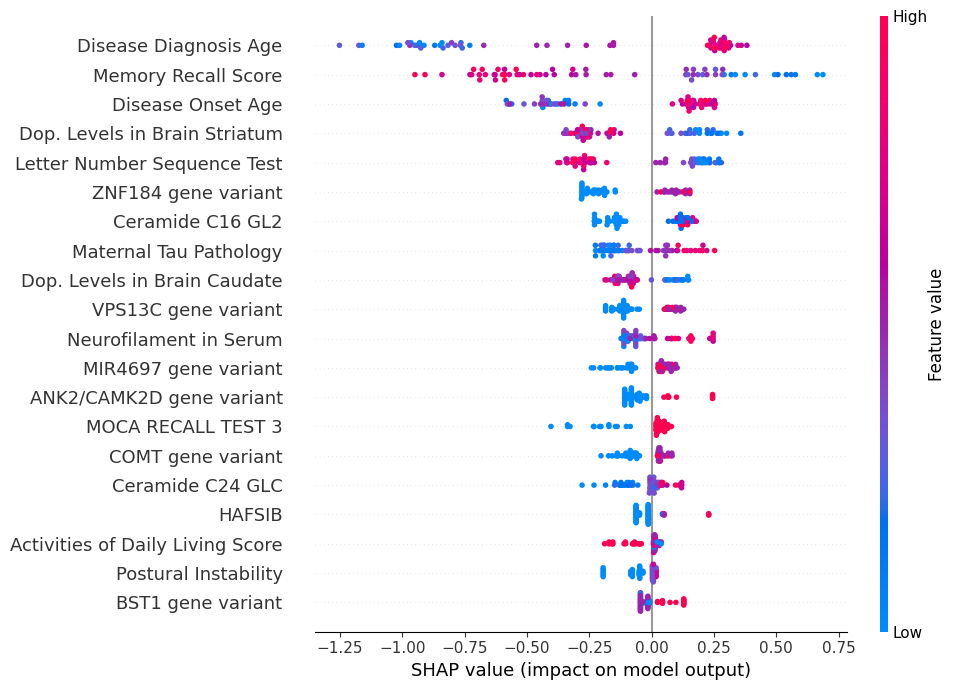

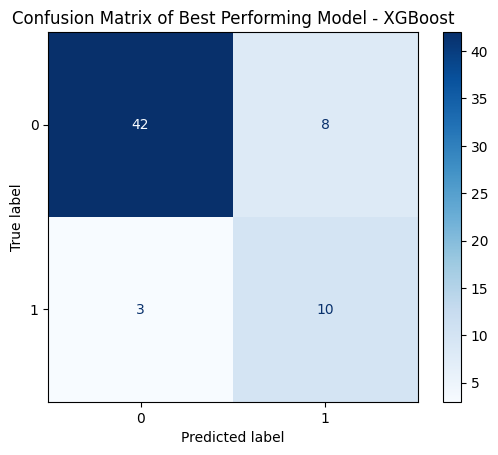

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        50
           1       0.56      0.77      0.65        13

    accuracy                           0.83        63
   macro avg       0.74      0.80      0.76        63
weighted avg       0.86      0.83      0.83        63



In [44]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


################################################## Train the final model which has all data features, on the best parameters #################################
# This are the best parameters we obtained from the best model with all the data features 
best_params = {
    'learning_rate': 0.2939524519800386,
    'max_depth': 6,
    'n_estimators': 811,
    'min_child_weight': 5.922853798432822,
    'subsample': 0.9734537450758004,
    'colsample_bytree': 0.9657760473908843,
    'scale_pos_weight': 2.0103792988849736,
    'lambda': 14.676931136695497,
    'alpha': 12.385694732957617,
    'random_state': 42
}

# get the deataset for the one having both features modalities
X=X_both
y=y_both

# Use the predefined train and test indices
X_train_full = X.loc[train_indices].reset_index(drop=True)
X_heldout = X.loc[test_indices].reset_index(drop=True)
y_train_full = y.loc[train_indices].reset_index(drop=True)
y_heldout = y.loc[test_indices].reset_index(drop=True)

    # Preprocessing pipelines as described above
num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])
    
if categorical_cols_both:
 
        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, numerical_cols_both),
                ('cat', cat_transformer, categorical_cols_both)
            ],
            remainder='drop'  
        )
else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, numerical_cols_both)
            ],
            remainder='drop'  
        )
    
    # Preprocess the full training dataset, and transform the held out, unseen data
X_train_full_preprocessed = preprocessor.fit_transform(X_train_full)
X_heldout_preprocessed = preprocessor.transform(X_heldout)
    
    # SMOTE on the full training set, for class imbalance
smote = SMOTE(random_state=42)
X_train_full_smote, y_train_full_smote = smote.fit_resample(X_train_full_preprocessed, y_train_full)


# Train the final model with the best parameters
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train_full_smote, y_train_full_smote)

##################################### SHAP FEATURE IMPORTANCE ####################################################################
# Generate SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_heldout_preprocessed)

# obtain feature names from the ohe hot encoder, or just the numerical feature names if not categorical
if categorical_cols_both:
    onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_both)
    feature_names = numerical_cols_both + list(onehot_feature_names)
else:
    feature_names = numerical_cols_both

# define more understandable feature names
feature_name_mapping = {
    'mean_caudate': 'Dop. Levels in Brain Caudate',
    'C16 GL2': 'Ceramide C16 GL2',
    'C24:1 GlcCer': 'Ceramide C24 GLC',
    'ageonset': 'Disease Onset Age',
    'hvlt_immediaterecall': 'Memory Recall Score',
    'agediag': 'Disease Diagnosis Age',
    'APOE_e3/e4': 'APOE E3/E4 genetic copies',
    'chr11:133895472:T:C_T_MIR4697_rs329648': 'MIR4697 gene variant',  
    'age': 'Patient Age', 
    'lns': 'Letter Number Sequence Test',  
    'chr6:27713436:G:A_A_ZNF184_rs9468199': 'ZNF184 gene variant',  
    'MCI_testscores': 'Mild Cog. Impairment Status',  
    'chr20:3172857:G:A_A_DDRGK1_rs55785911': 'DDRGK1 gene variant', 
    'updrs2_score': 'Daily Activity Difficulties',  
    'mean_striatum': 'Dop. Levels in Brain Striatum',  
    'nfl_serum': 'Neurofilament in Serum', 
    'MCAREC1': 'MOCA RECALL 1', 
    'KIDSNUM': 'KIDS NUMBER',  
    'chr22:19942586:T:C_C_COMT_rs737866': 'COMT gene variant', 
    'chr12:122819039:A:G_G_OGFOD2/CCDC62_rs11060180': 'OGFOD2/CCDC62 gene variant',  
    'MATAU': 'Maternal Tau Pathology',
    'MSEADLG': 'Activities of Daily Living Score',
    'chr15:61701935:G:A_G_VPS13C_rs2414739': "VPS13C gene variant",
    'chr4:113439216:T:C_C_ANK2/CAMK2D_rs78738012': "ANK2/CAMK2D gene variant",
    'chr22:19946502:A:G_A_COMT_rs174674': "COMT gene variant",
    'chr4:15735478:C:A_C_BST1_rs11724635': "BST1 gene variant",
    "MCAREC3": "MOCA RECALL TEST 3",
    "pigd": "Postural Instability"
    
     
}



# update feature names 
feature_names = [feature_name_mapping.get(name, name) for name in feature_names]

# store SHAP values
shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

# SHAP summary plot

x=shap.summary_plot(shap_values, X_heldout_preprocessed, feature_names=feature_names, plot_size=(10, 7))


# confusion matrix on the final data hold out
y_pred = final_model.predict(X_heldout_preprocessed)
cm = confusion_matrix(y_both.loc[test_indices], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of Best Performing Model - XGBoost')
plt.show()


print(classification_report(y_both.loc[test_indices], y_pred))

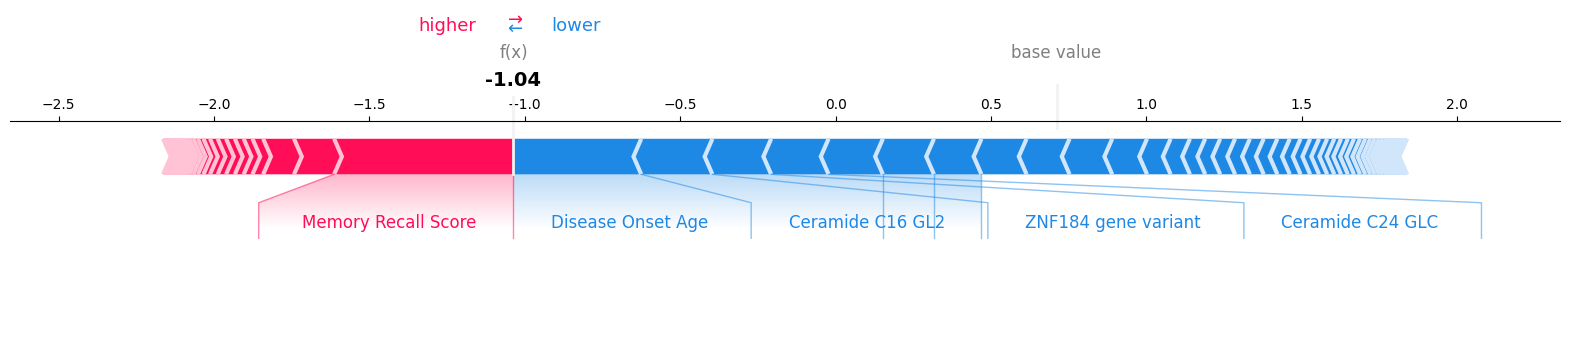

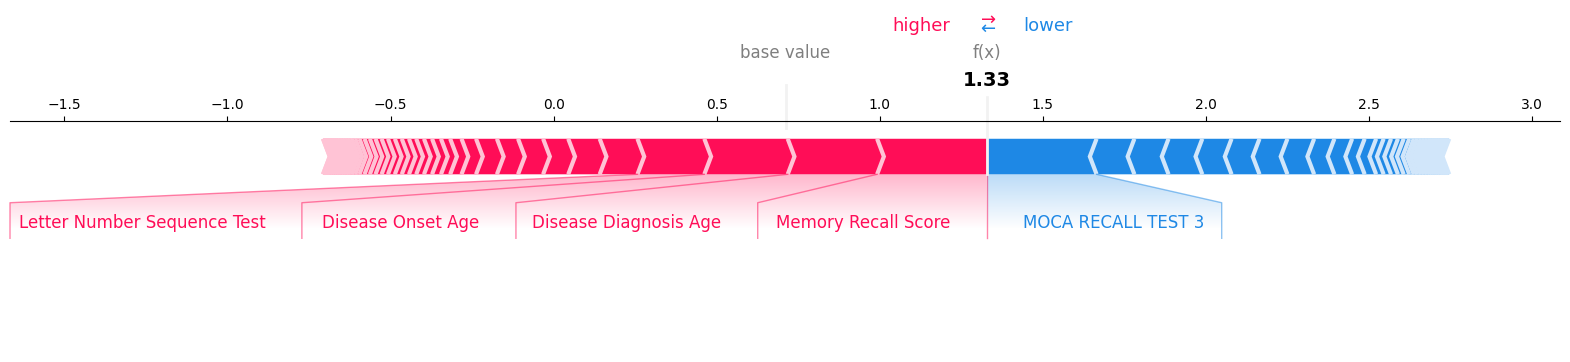

In [45]:
#############################################  FORCE PLOT TO EXPLAIN 2 PREDICITONS MADE ###############################
import shap
import matplotlib.pyplot as plt
import numpy as np

# predictions on the preprocessed held-out test set
y_pred = final_model.predict(X_heldout_preprocessed)

# fnct to plot SHAP force plots with all features, keeping top 5 labelled
## THIS IS DONE JSUT FOR A CLEANER DATA VISUALIZATION. LABELLING TOO MANY FEATURES BECOMES MESSY, AS WELL AS PLOTTING THEIR INDIVIDUAL VALUES
def plot_force_plots_with_top_labels(indices, class_label):
    for idx in indices:
        # extract the shap vals from the indicated row
        shap_values_instance = shap_values[idx, :]
        
        # index of the top important features by shap
        top_5_features_idx = np.argsort(np.abs(shap_values_instance))[-5:]
        
        # list of feature names with only top 5 labeled, others are empty strings. 
        labeled_feature_names = [
            feature_names[i] if i in top_5_features_idx else "" for i in range(len(feature_names))
        ]
        
        # SHAP force plotting
        shap.force_plot(
            explainer.expected_value,
            shap_values_instance,
            feature_names=labeled_feature_names,
            matplotlib=True,
            show=False
        )
        
        plt.show()

# indices for class 0 and class 1 predictions
class_0_indices = np.where(y_pred == 0)[0]
class_1_indices = np.where(y_pred == 1)[0]

# picking 1 random patients for each class
class_0_patients = class_0_indices[4:5]
class_1_patients = class_1_indices[10:11]

# class 0 plt force
plot_force_plots_with_top_labels(class_0_patients, class_label=0)

# class 1 plt force
plot_force_plots_with_top_labels(class_1_patients, class_label=1)
